
# 章節 3-2 RFM 模型實戰

author: 鍾皓軒 （臺灣行銷研究有限公司創辦人）

## 資料
以下是某一賣場的匿名資料，我們挑選出其中三件商品，切入R 及F 的模型分
析。本次資料共4,384 筆資料，可在我們所提供的QR code 下載，或點擊[本鏈接](https://bit.ly/Python-RFM-RF-basics-data)下載。而該賣場的內部資料有以下
欄位：

* 產品（product）：本資料集含咖啡（coffee）、燕麥麵包（oatmeal bread）
與瓶裝水（bottled water）共三種產品為例。產品部份礙於賣場揭露之限
制，所以僅擷取產品大分類。
* 交易代號（orderId）：每一筆交易的代號
* 顧客編號（clientId）：每一位顧客的專屬編號
* 性別（gender）：分為男（male）與女（female）
* 交易日期（orderdate）為顧客購買產品時的時間

In [1]:
# 載入必要套件
import pandas as pd
import seaborn as sns
import RFM

# 動態繪圖套件
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import numpy as np
import plotly.express as px
import tools
import seaborn as sns

theOS, ecode = tools.checkPlatform()

## 載入資料

In [2]:
''' 
資料讀取 
    注意編碼問題，尤其是windows作業系統出來的檔案，都有獨特的編碼格式。
'''
orders= pd.read_csv( 'orders2.csv', encoding=ecode)


#空值該列全部刪除
orders.dropna(inplace = True)
orders

,product,orderId,clientId,gender,orderdate,grossmarg
0,coffee,582,230,female,1/8/2018,45
1,coffee,2,276,male,2/18/2018,45
2,coffee,725,277,female,2/3/2018,45
3,coffee,597,279,male,3/5/2018,45
4,coffee,761,92,female,2/8/2018,45
...,...,...,...,...,...,...
4379,bottled water,501,215,male,4/9/2018,25
4380,bottled water,1000,273,female,1/6/2018,25
4381,bottled water,502,13,male,3/13/2018,25
4382,bottled water,502,13,male,3/13/2018,25


# 資料處理

In [3]:

# 設定今天的日期： 2018/4/11
'從今天來看過往的銷售狀況'
from dateutil import parser
assess_date = parser.parse('2018-04-11')
start_date= parser.parse('2018-01-01')

type(assess_date)
type('2018-04-11')

# 計算每個人在三個產品的消費數量與時間
df2, recent_recency, frequency = RFM.RFM_cal(orders,start_date,assess_date)

# merge recency
df2 = recent_recency.merge(df2, on = ['clientId', 'orderdate'])

# frequency merge
df2 =df2.merge(frequency, on = ['clientId'])



In [4]:
# 成果將每一個人的product進行攤平，並計算出Recency與Frequency
df2

product,clientId,orderdate,recency,gender,bottled water,coffee,oatmeal bread,frequency
0,1,2018-04-03,8,male,2.0,0.0,2.0,5
1,2,2018-03-31,11,male,4.0,0.0,1.0,1
2,3,2018-04-10,1,female,0.0,1.0,0.0,6
3,4,2018-02-01,69,female,2.0,1.0,1.0,1
4,5,2018-03-26,16,male,0.0,0.0,1.0,4
...,...,...,...,...,...,...,...,...
284,296,2018-03-13,29,male,1.0,0.0,2.0,4
285,297,2018-04-08,3,female,4.0,1.0,1.0,2
286,298,2018-03-21,21,female,1.0,0.0,2.0,3
287,299,2018-01-27,74,female,2.0,0.0,0.0,1


## 最近一次（天）的消費與顧客數量分佈圖

In [5]:

# 最近一次（天）的消費與顧客數量分佈圖
df2['顧客數量'] = 1
recency_table = df2.groupby('recency', as_index = False)['顧客數量'].sum()

fig = px.bar(recency_table, y='顧客數量', x='recency', text ='顧客數量' )
fig.update_traces(texttemplate='%{text:}人', textposition='outside')
fig.update_layout(
    title="最近一次（天）的消費與顧客數量分佈圖",
    xaxis_title="距離上次購買的天數",
    yaxis_title="顧客數量",
    font=dict(
        size=18,
    )
)

fig.show()

# 如果是在離線python script，請使用下述方法，會將html一同存到您的工作目錄
# plot(fig, filename='最近一次（天）的消費與顧客數量分佈圖.html')

## 消費頻率與顧客數量分佈圖

In [6]:

# 消費頻率與顧客數量分佈圖
df2['顧客數量'] = 1
frequency_table = df2.groupby('frequency', as_index = False)['顧客數量'].sum()

fig = px.bar(frequency_table, y='顧客數量', x='frequency', text ='顧客數量' )
fig.update_traces(texttemplate='%{text:}人', textposition='outside')
fig.update_layout(
    title="消費頻率與顧客數量分佈圖",
    xaxis_title="消費頻率",
    yaxis_title="顧客數量",
    font=dict(
        size=18,
    )
)
fig.show()
# plot(fig, filename='消費頻率與顧客數量分佈圖.html')

## 進行階層式分群演算法（Hierarchical Clustering）

In [7]:

# clustering 
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters = 6, affinity='euclidean', linkage='ward')
recency_table['cluster'] = cluster.fit_predict(recency_table)
frequency_table['cluster'] = cluster.fit_predict(frequency_table)

In [8]:
frequency_table

product,frequency,顧客數量,cluster
0,1,44,4
1,2,58,0
2,3,62,0
3,4,58,0
4,5,35,3
5,6,16,5
6,7,11,2
7,8,3,1
8,9,2,1


In [9]:
recency_table

product,recency,顧客數量,cluster
0,0,13,0
1,1,8,0
2,2,4,0
3,3,16,0
4,4,10,0
...,...,...,...
73,82,1,2
74,84,1,2
75,85,1,2
76,88,1,2


## 【分群後】最近一次（天）的消費與顧客數量分佈圖

In [10]:

# 【分群後】最近一次（天）的消費與顧客數量分佈圖
recency_table['cluster'] = recency_table['cluster'].astype(str)

fig = px.bar(recency_table, y='顧客數量', x='recency', text ='顧客數量' ,
             color =recency_table['cluster']  )
fig.update_traces(texttemplate='%{text:}人', textposition='outside')
fig.update_layout(
    title="【分群後】最近一次（天）的消費與顧客數量分佈圖",
    xaxis_title="距離上次購買的天數",
    yaxis_title="顧客數量",
    font=dict(
        size=18,
    )
)
fig.show()
# plot(fig, filename='【分群後】最近一次（天）的消費與顧客數量分佈圖.html')


## 【分群後】消費頻率與顧客數量分佈圖

In [11]:

# 【分群後】消費頻率與顧客數量分佈圖
frequency_table['cluster'] = frequency_table['cluster'].astype(str)

fig = px.bar(frequency_table, y='顧客數量', x='frequency', text ='顧客數量' ,
             color=frequency_table['cluster'])
# ['red','blue','blue','blue','blue','blue','blue','blue','blue']
fig.update_traces(texttemplate='%{text:}人', textposition='outside')
fig.update_layout(
    title="【分群後】消費頻率與顧客數量分佈圖",
    xaxis_title="消費頻率",
    yaxis_title="顧客數量",
    font=dict(
        size=18,
    )
)
fig.show()
# plot(fig, filename='【分群後】消費頻率與顧客數量分佈圖.html')


## 要開始將Recency與Frequency進行顧客分羣
我們會根據上述分羣的結果作爲切割準則,分成
* 頻率分類
* 近因分類


In [12]:

# 切割 recency
recency_label =  ['0-17 day', '18-27 day', '28-40 day', '41-56 day', '57-68 day', '>69 day']
recency_cut  = [-1, 17, 27, 40, 56, 68, df2['recency'].max()]
df2['近因'] = pd.cut( 
        df2['recency'] , #目標欄位
        recency_cut, #切割條件
        labels =recency_label) #切割後的分類內容

# 切割 frequency
frequency_label =  ['1 freq', '2-4 freq', '5 freq', '6 freq', '7 freq', '>8 freq']
frequency_cut  = [-1, 2, 4, 5, 6, 7, df2['frequency'].max()]
df2['頻率'] = pd.cut( 
        df2['frequency'] , #目標欄位
        frequency_cut,  #切割條件
        labels =frequency_label) #切割後的分類內容



In [13]:
# 從下表中，我們可以看到不同等級的recency與Frequency被歸類到「頻率」與「近因」的分類欄位裏面
df2

product,clientId,orderdate,recency,gender,bottled water,coffee,oatmeal bread,frequency,顧客數量,近因,頻率
0,1,2018-04-03,8,male,2.0,0.0,2.0,5,1,0-17 day,5 freq
1,2,2018-03-31,11,male,4.0,0.0,1.0,1,1,0-17 day,1 freq
2,3,2018-04-10,1,female,0.0,1.0,0.0,6,1,0-17 day,6 freq
3,4,2018-02-01,69,female,2.0,1.0,1.0,1,1,>69 day,1 freq
4,5,2018-03-26,16,male,0.0,0.0,1.0,4,1,0-17 day,2-4 freq
...,...,...,...,...,...,...,...,...,...,...,...
284,296,2018-03-13,29,male,1.0,0.0,2.0,4,1,28-40 day,2-4 freq
285,297,2018-04-08,3,female,4.0,1.0,1.0,2,1,0-17 day,1 freq
286,298,2018-03-21,21,female,1.0,0.0,2.0,3,1,18-27 day,2-4 freq
287,299,2018-01-27,74,female,2.0,0.0,0.0,1,1,>69 day,1 freq


# RFM 分析開始！


## RFM顧客區隔面（RF交叉分析）

In [14]:
# RF交叉分析
RF_table = pd.crosstab(df2['頻率'].astype(str),
                       df2['近因'].astype(str))

# 重新排序
RF_table['freq'] = RF_table.index
# RF_table = RF_table.sort_values('freq',ascending = False)

collist = ['freq'] + recency_label
RF_table = RF_table[collist]

In [15]:
RF_table

近因,freq,0-17 day,18-27 day,28-40 day,41-56 day,57-68 day,>69 day
頻率,,,,,,,
1 freq,1 freq,28,17,16,13,11,17
2-4 freq,2-4 freq,64,18,19,13,4,2
5 freq,5 freq,22,4,9,0,0,0
6 freq,6 freq,11,3,0,2,0,0
7 freq,7 freq,8,1,2,0,0,0
>8 freq,>8 freq,4,1,0,0,0,0


## 定義顧客

In [16]:

# 以個別消費者來說，這四種顧客分別是個體的誰？
# 分類並標示出新客戶、常貴客、先前客
df2['customer'] = np.where( (df2['frequency'] >=frequency_cut[4]) & (df2['recency']<=recency_cut[3]), '常貴客',
   
                     np.where( (df2['frequency'] >=frequency_cut[4]) & ( df2['recency']>recency_cut[3]), '沉睡客',
                              
                              np.where( (df2['frequency'] < frequency_cut[4]) & ( df2['recency']>recency_cut[3]), '流失客',
                                       
                                       '新顧客'  )))

In [17]:
# customer即爲本次定義的顧客部分
df2

product,clientId,orderdate,recency,gender,bottled water,coffee,oatmeal bread,frequency,顧客數量,近因,頻率,customer
0,1,2018-04-03,8,male,2.0,0.0,2.0,5,1,0-17 day,5 freq,新顧客
1,2,2018-03-31,11,male,4.0,0.0,1.0,1,1,0-17 day,1 freq,新顧客
2,3,2018-04-10,1,female,0.0,1.0,0.0,6,1,0-17 day,6 freq,常貴客
3,4,2018-02-01,69,female,2.0,1.0,1.0,1,1,>69 day,1 freq,流失客
4,5,2018-03-26,16,male,0.0,0.0,1.0,4,1,0-17 day,2-4 freq,新顧客
...,...,...,...,...,...,...,...,...,...,...,...,...
284,296,2018-03-13,29,male,1.0,0.0,2.0,4,1,28-40 day,2-4 freq,新顧客
285,297,2018-04-08,3,female,4.0,1.0,1.0,2,1,0-17 day,1 freq,新顧客
286,298,2018-03-21,21,female,1.0,0.0,2.0,3,1,18-27 day,2-4 freq,新顧客
287,299,2018-01-27,74,female,2.0,0.0,0.0,1,1,>69 day,1 freq,流失客


## 以視覺化呈現 RFM顧客區隔面（RF交叉分析）

In [18]:

# 以頻率與近因爲羣組，統計他們的顧客數量
df_seg = df2.groupby(['頻率', '近因'], as_index = False)['顧客數量'].sum()


In [19]:
df_seg

product,頻率,近因,顧客數量
0,1 freq,0-17 day,28.0
1,1 freq,18-27 day,17.0
2,1 freq,28-40 day,16.0
3,1 freq,41-56 day,13.0
4,1 freq,57-68 day,11.0
5,1 freq,>69 day,17.0
6,2-4 freq,0-17 day,64.0
7,2-4 freq,18-27 day,18.0
8,2-4 freq,28-40 day,19.0
9,2-4 freq,41-56 day,13.0


In [20]:
# 要將customer分類融合到df_seg裏面，這樣才可以繪製不同區隔顏色的圖
df_seg = df_seg.merge(df2[['頻率', '近因','customer']],
        on =['頻率', '近因'], how = 'left')

df_seg = df_seg.drop_duplicates()

df_seg

product,頻率,近因,顧客數量,customer
0,1 freq,0-17 day,28.0,新顧客
28,1 freq,18-27 day,17.0,新顧客
45,1 freq,28-40 day,16.0,新顧客
61,1 freq,41-56 day,13.0,流失客
74,1 freq,57-68 day,11.0,流失客
85,1 freq,>69 day,17.0,流失客
102,2-4 freq,0-17 day,64.0,新顧客
166,2-4 freq,18-27 day,18.0,新顧客
184,2-4 freq,28-40 day,19.0,新顧客
203,2-4 freq,41-56 day,13.0,流失客


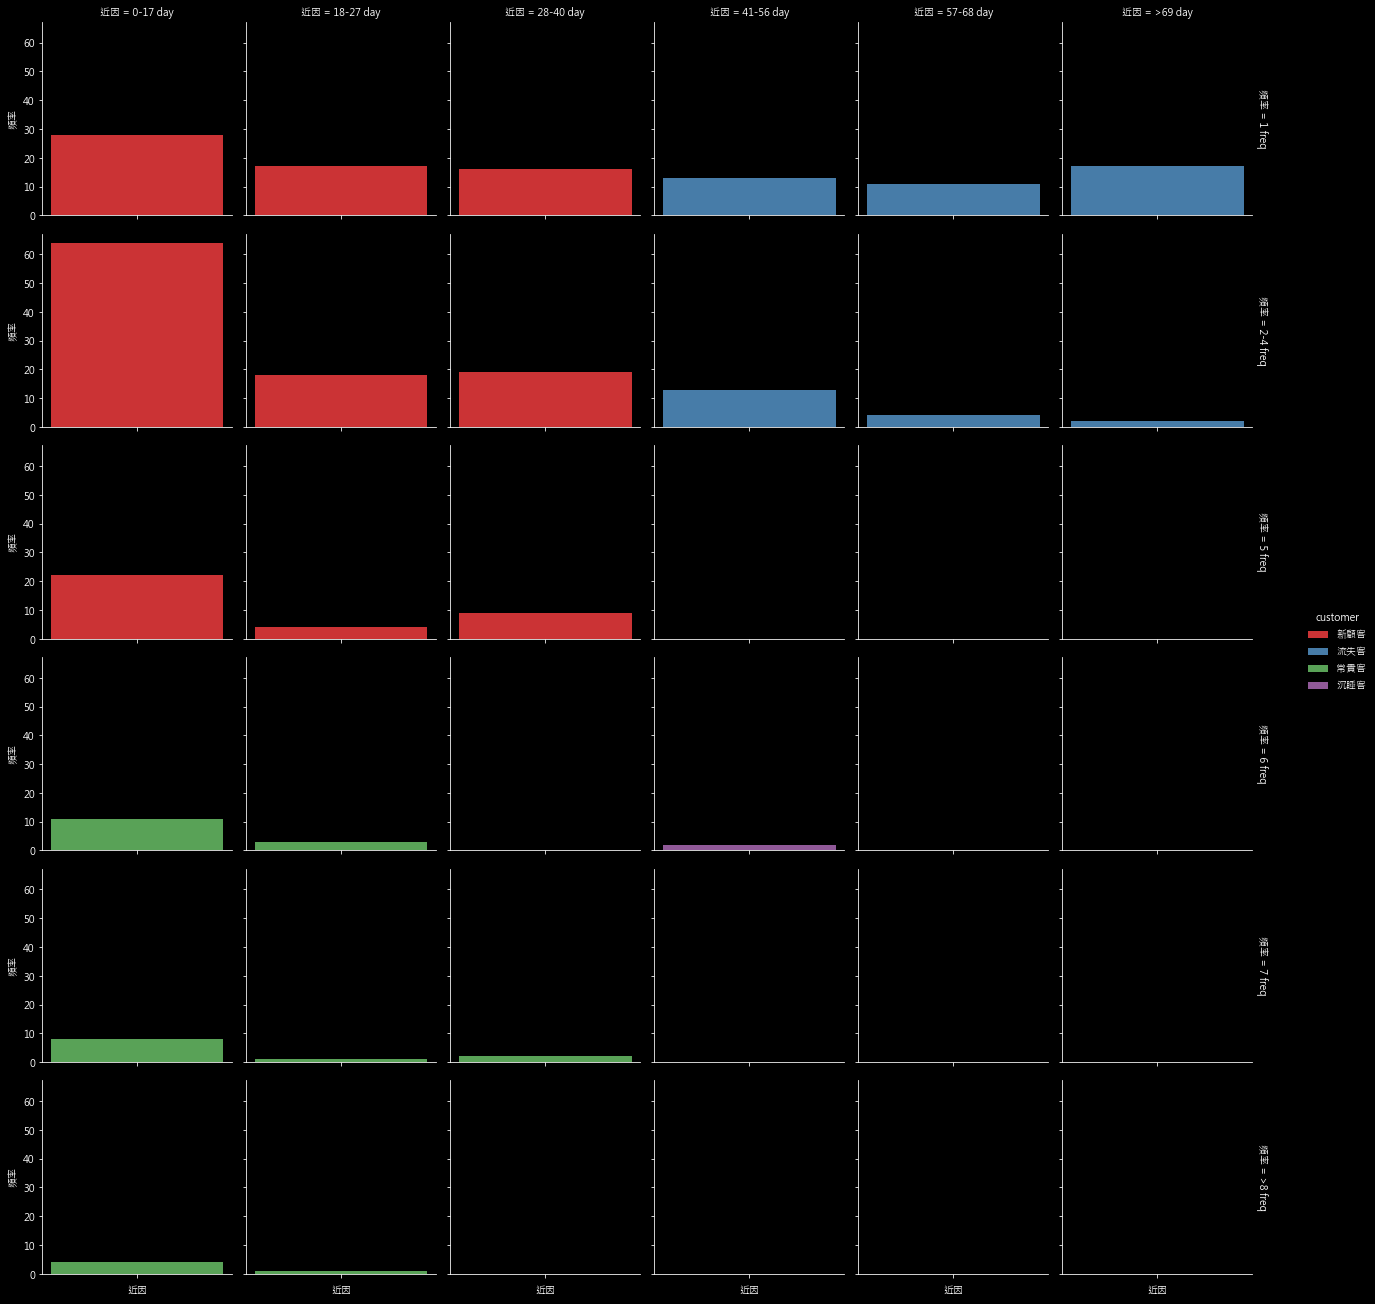

In [21]:


#--- 繪圖
df_seg = df_seg.rename(columns = {'recency_cate':'近因'})
df_seg = df_seg.rename(columns = {'frequency_cate':'頻率'})

g = sns.FacetGrid(df_seg, # 來源資料表
                  col="近因", # X資料來源欄位
                  row="頻率" ,  # Y資料來源欄位
                  col_order= recency_label,  # X資料順序
                  row_order= frequency_label, # Y資料順序
                  palette='Set1',  #畫布色調
                  margin_titles=True,
                  hue='customer'
                  )
#小圖表部分
g = g.map_dataframe(sns.barplot, y ='顧客數量')
g = g.set_axis_labels('近因','頻率').add_legend()
g.savefig("RFplot.png")


## 顧客產品推薦長條圖（依性別分類）

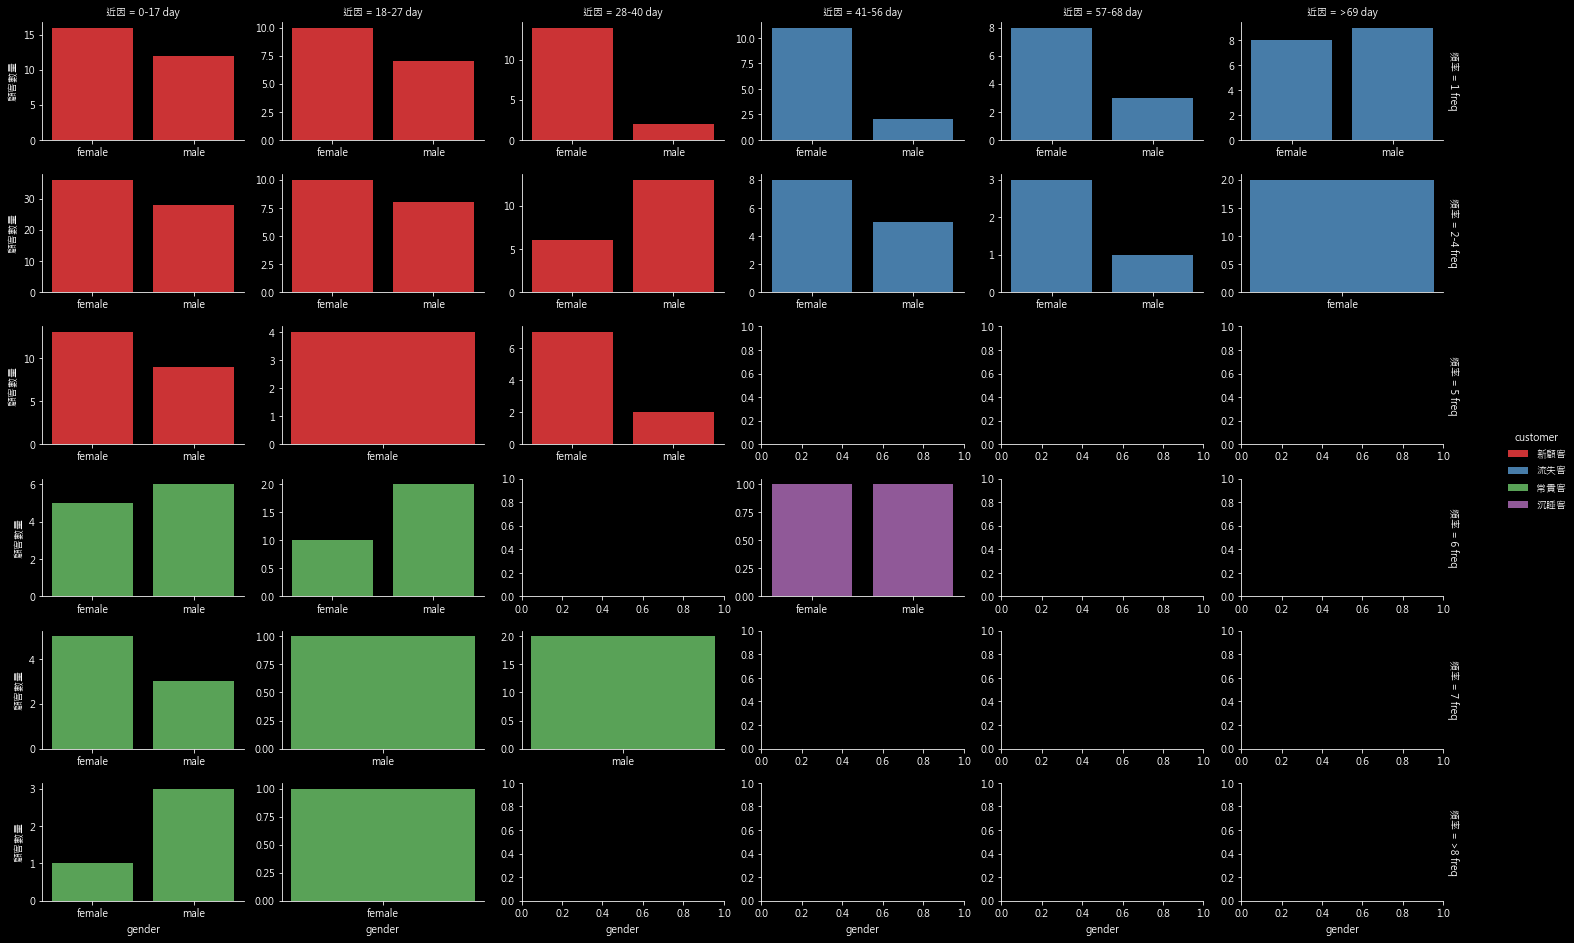

In [22]:

######### 製圖 #######

df_seg = df2.groupby(['頻率', '近因','gender'], as_index = False)['顧客數量'].sum()

df_seg = df_seg.merge(df2[['頻率', '近因','customer']],
        on =['頻率', '近因'], how = 'left')
df_seg = df_seg.drop_duplicates()

# 顧客產品推薦圖 - 長條圖
g = sns.FacetGrid(df_seg, # 來源資料表
                  col="近因", # X資料來源欄位
                  row="頻率" ,  # Y資料來源欄位
                    col_order= recency_label,  # X資料順序
                    row_order= frequency_label, # Y資料順序
                    sharex=False,
            sharey=False,
                    size=2.2, aspect=1.6,
                  palette='Set1',  #畫布色調
                    margin_titles=True,
                    hue='customer'
                  )
#小圖表部分
g = g.map(sns.barplot, 'gender' ,'顧客數量')
g = g.add_legend()
g.savefig("顧客產品推薦長條圖（依性別分類）.png")

## 顧客產品推薦堆疊圖（依產品分類）

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4b4540cb10>,
 <Figure size 1800x1080 with 36 Axes>)

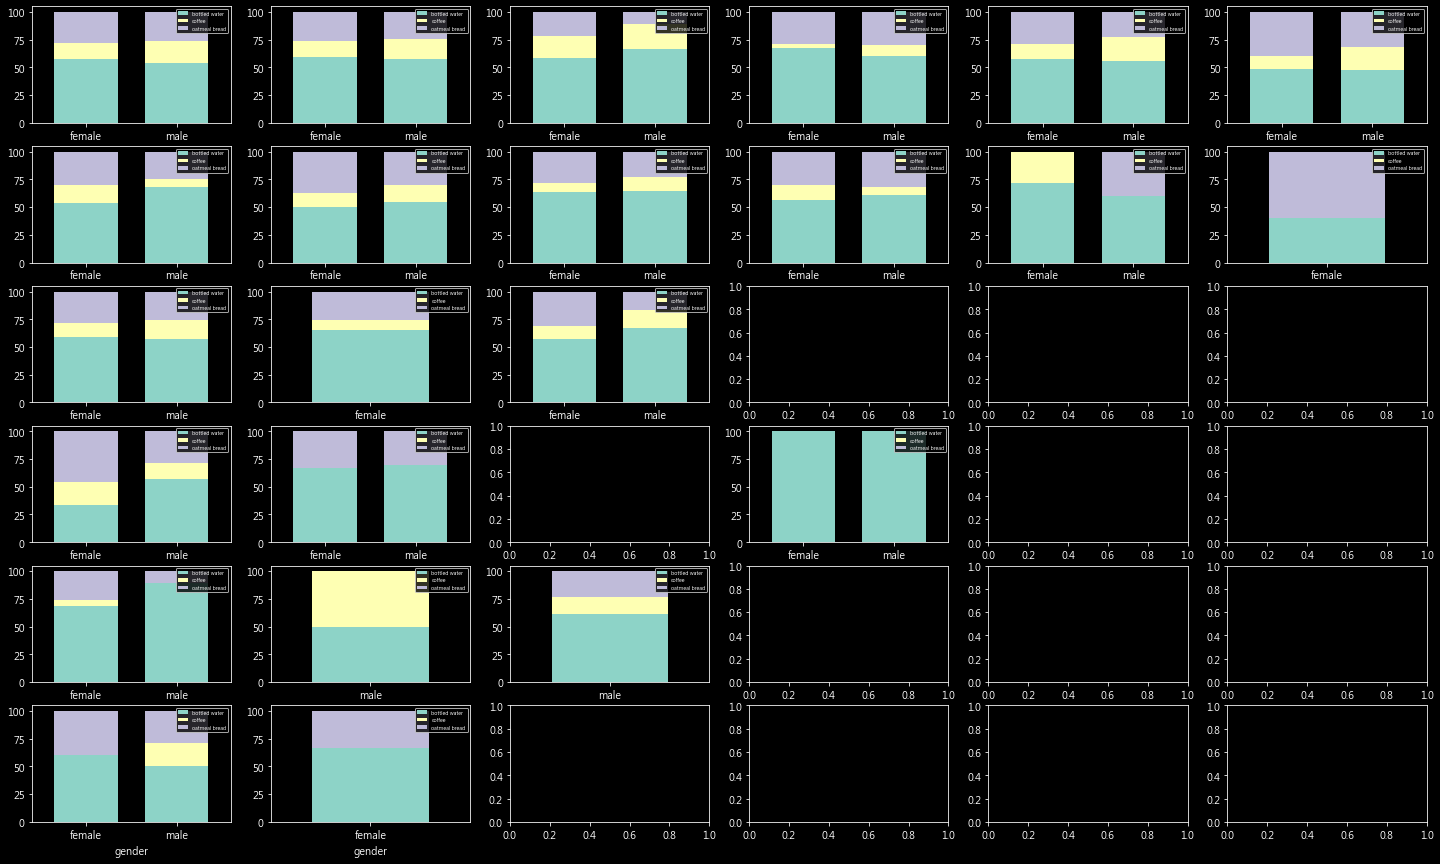

In [23]:
# 顧客產品推薦圖 - 堆疊圖
del df2['顧客數量']
RFM.RFM_stackedplot(df2, frequency_label,recency_label,'gender')


## 個人商品推薦

In [24]:
# 商品個別推薦

product =  orders['product'].unique().tolist()

recom_list = []
for i in range(len(df2[product])):
    aa = df2[product].iloc[i,::].rank().sort_values(ascending = False)
    recom_list.append('、'.join(aa.index))
    
df2['recommend_product'] =recom_list




In [25]:
# 在recommend_product裏面看到每一個人的推薦產品
df2

product,clientId,orderdate,recency,gender,bottled water,coffee,oatmeal bread,frequency,近因,頻率,customer,recommend_product
0,1,2018-04-03,8,male,2.0,0.0,2.0,5,0-17 day,5 freq,新顧客,bottled water、oatmeal bread、coffee
1,2,2018-03-31,11,male,4.0,0.0,1.0,1,0-17 day,1 freq,新顧客,bottled water、oatmeal bread、coffee
2,3,2018-04-10,1,female,0.0,1.0,0.0,6,0-17 day,6 freq,常貴客,coffee、bottled water、oatmeal bread
3,4,2018-02-01,69,female,2.0,1.0,1.0,1,>69 day,1 freq,流失客,bottled water、oatmeal bread、coffee
4,5,2018-03-26,16,male,0.0,0.0,1.0,4,0-17 day,2-4 freq,新顧客,oatmeal bread、bottled water、coffee
...,...,...,...,...,...,...,...,...,...,...,...,...
284,296,2018-03-13,29,male,1.0,0.0,2.0,4,28-40 day,2-4 freq,新顧客,oatmeal bread、bottled water、coffee
285,297,2018-04-08,3,female,4.0,1.0,1.0,2,0-17 day,1 freq,新顧客,bottled water、oatmeal bread、coffee
286,298,2018-03-21,21,female,1.0,0.0,2.0,3,18-27 day,2-4 freq,新顧客,oatmeal bread、bottled water、coffee
287,299,2018-01-27,74,female,2.0,0.0,0.0,1,>69 day,1 freq,流失客,bottled water、oatmeal bread、coffee


## 後續練習：大家可以嘗試看看如何將不同區隔的顧客區分出來，找出各自的顧客推薦清單
